### Import useful libraries

This project was done in the scope of the CS-439 : Optimization for ML course. The project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

In this notebook, we focus on the analysis of the SGD optimizer.

In [1]:
# Import useful libraries for computation
import numpy as np

# Import torch and libraries to deal with NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Import pyhessian to deal with second order information
from pyhessian import hessian # Hessian computation
import copy

# Import usefil library to visualize results
import matplotlib.pyplot as plt

# Importing the LeNet5 architecture we are going to use for our study and comparisons
from cnn_architectures import *

# Importing parameters to use with different optimizers before comparing them
import params

# Importing useful functions
from helpers import *

# Ignoring warnings to make the code more readable
import warnings
warnings.filterwarnings("ignore")

# Useful libraries to create directories
from os import makedirs
from shutil import rmtree

%load_ext autoreload
%autoreload 2

### Setting the parameters and additional variables

In [2]:
# Defininig neural network's parameters and seed for reproducibility purposes
RANDOM_SEED = 42
IMG_SIZE = 32
N_CLASSES = 10


# Checking device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

### Loading, reshaping and plotting  data (SGD)

In [3]:
# Loading data
transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.SGD_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.SGD_BATCH_SIZE, 
                          shuffle=False)

### Moving data to local device in order to visualize them (and use them later)

In [4]:
# Reshaping train data (from 28*28 to 32*32) for visualization purposes
train_data, train_target = reshape_train_data(raw_mnist_trainset, DEVICE)
# Reshaping test data (from 28*28 to 32*32) for visualization purposes
test_data, test_target = reshape_test_data(raw_mnist_trainset, DEVICE)

## Model training and Model Evaluation using SGD

First, we train our model using LeNet5. The model was trained using hyperparameters you can find in `helpers.py`. 

In [5]:
# Defining data to compute the stochastic approximation of the hessian and its eigenvalues
# along the training trajectory (the choice of the batch size is fundamental, see report)
indices = np.random.choice(len(train_data),1000) # restricted samples because of limited computational resources
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)
data_for_spectral_gap = [hessian_input, hessian_label]

# Initializing the model we are going to use in our study
model = LeNet5(num_classes=N_CLASSES).to(DEVICE)

# Defining the criterion (loss function) to be used during the training procedure
criterion = nn.CrossEntropyLoss()

# Defining and initializing the optimizer (ADAM in this notebook)
optimizer = torch.optim.SGD(model.parameters(), lr=params.SGD_LEARNING_RATE)

# Adding this variable to know the number of iterations to compute in every epoch
iter_per_epoch = len(train_data) / params.SGD_BATCH_SIZE

Let's train and test our first model

In [7]:
model, optimizer, losses, grad_norms, spectral_gap = training_loop(model, criterion, optimizer, train_loader, test_loader, params.SGD_N_EPOCHS,
                                    DEVICE, data_for_spectral_gap, iter_per_epoch)

16:26:29 --- Epoch: 0	Train loss: 2.2564	Valid loss: 2.1158	Train accuracy: 46.96	Valid accuracy: 47.02
16:26:47 --- Epoch: 1	Train loss: 1.4857	Valid loss: 0.8882	Train accuracy: 78.10	Valid accuracy: 78.55
16:27:05 --- Epoch: 2	Train loss: 0.6805	Valid loss: 0.5300	Train accuracy: 85.70	Valid accuracy: 86.55
16:27:24 --- Epoch: 3	Train loss: 0.4803	Valid loss: 0.4166	Train accuracy: 88.44	Valid accuracy: 88.93
16:27:42 --- Epoch: 4	Train loss: 0.4007	Valid loss: 0.3589	Train accuracy: 89.53	Valid accuracy: 90.26
16:28:01 --- Epoch: 5	Train loss: 0.3557	Valid loss: 0.3237	Train accuracy: 90.37	Valid accuracy: 91.00
16:28:19 --- Epoch: 6	Train loss: 0.3238	Valid loss: 0.2965	Train accuracy: 91.08	Valid accuracy: 91.58
16:28:37 --- Epoch: 7	Train loss: 0.2978	Valid loss: 0.2722	Train accuracy: 91.72	Valid accuracy: 92.25
16:28:55 --- Epoch: 8	Train loss: 0.2755	Valid loss: 0.2519	Train accuracy: 92.29	Valid accuracy: 92.76
16:29:13 --- Epoch: 9	Train loss: 0.2553	Valid loss: 0.2338	Trai

We now save both the model and the results to later obtain the plots to use when writing the report

In [8]:
makedirs('./checkpoints', exist_ok=True)
PATH = './checkpoints/sgd_final_model'

torch.save(model.state_dict(), PATH + '.pt')
np.savetxt('./checkpoints/sgd_grad_norms', np.array(grad_norms))
np.savetxt('./checkpoints/sgd_spectral_gap', np.array(spectral_gap))

Plot the gradient norm, which has been proven to be an important factor related to generalization properties of the architecture.

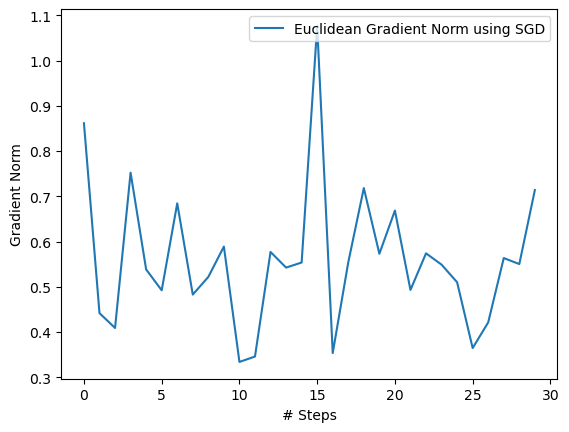

In [9]:
plot_gradient_norm(grad_norms[-30:], method = 'SGD')

Plot the confusion matrix in order to observe the in-class accuracy.

<Axes: xlabel='Predicted label', ylabel='True label'>

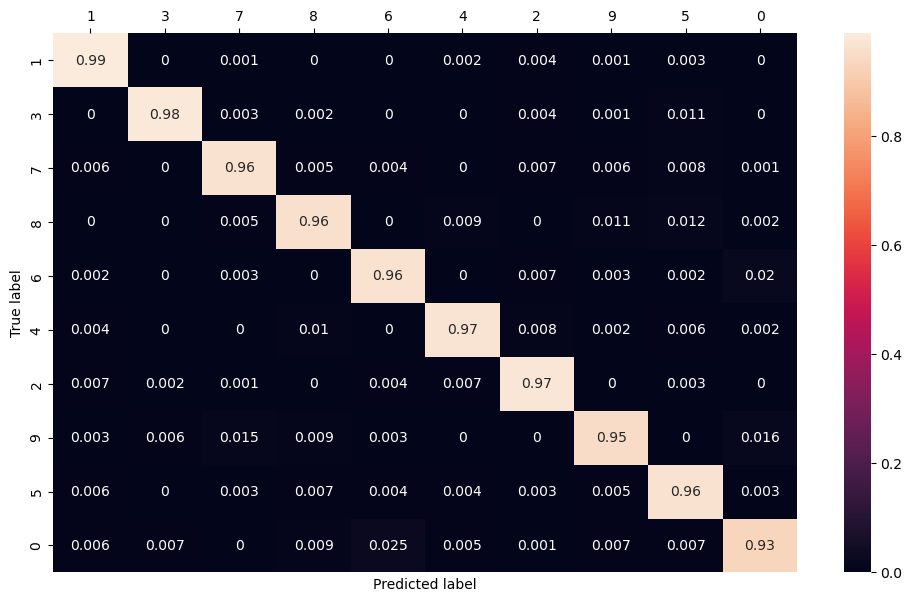

In [10]:
compute_confusion_matrix(test_loader, model, N_CLASSES)

Plot the spectral gap to discuss the possibility of introducing second order information in the last phase of the training (see report for a better explanation and for a quick overview of the limitation of this method).

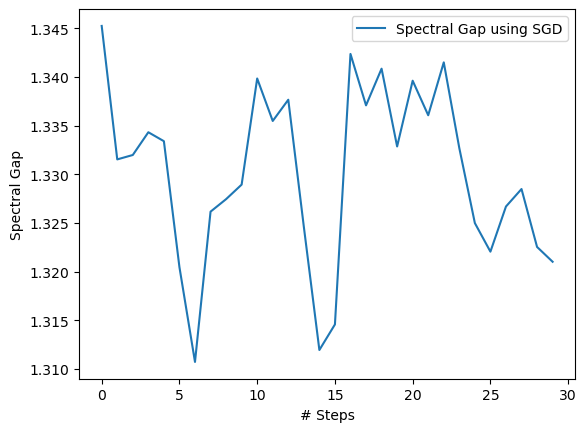

In [12]:
plot_spectral_gap(spectral_gap, method = 'SGD')

We now start looking at the eigenvalues in order to see whether we've reached a flat or sharp minimum. The top 2 largest and smallest eigenvalue are essential in order to observe how the second order approximation behaves in the neighborhood of the point to which we have converged (we assume, as shown in the previous plot, that the first order approximation given by the gradient is approximately zero). Notice that this analysis is different from the one provided with the spectral gap plot: here we focus on the point to which we have converged.

In [13]:
# We now divide the training dataset into batches to compute the hessian of the loss evaluated in the solution
indices = np.random.choice(len(train_data),1000)
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)


# We now compute the hessian matrix, to later retrieve the spectral norm and the eigenvalues
device_flag = True if torch.cuda.is_available() else False
model_to_plot = copy.deepcopy(model)
criterion = torch.nn.CrossEntropyLoss()
hessian_comp = hessian(model_to_plot, criterion, data=(hessian_input, hessian_label), cuda=device_flag)

# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)

# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
print("The top eigenvalue of this model is: %.4f "% (top_eigenvalues[0]))

The top eigenvalue of this model is: 6.1097 


We now plot the loss landscape. The plot below represents how the loss behaves in the directions given by the top eigenvector (direction of maximum perturbation and maximum stretch).

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

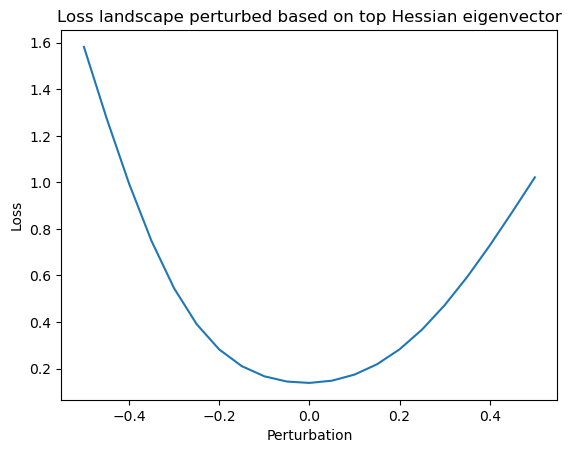

In [14]:
# Lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# At first, we initialized the perturb model to be the model obtained at the end of the training procedure
model_perb = copy.deepcopy(model)

# We now perturb the function in the direction given by the top eigenvector to visualize the quality of the minimum
for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')